# Task 2: Resnet18 on EuroSAT dataset for Image Classification

#### Name: Ankit Kumar Verma
#### R.No: 21CS60A04

#### Setting filepaths

In [10]:
dataset_path = '../Dataset/euroSAT_train_val_test.pkl'
logs_path = 'logs_resnet/'
is_wandb = False
is_drive_mount = False
training_loss = []
training_acc = []
validation_loss = []
validation_acc = []

#### Setting Model Parameters

In [33]:
best_acc = 0  
num_epochs = 200
learning_rate = 0.001
batch_size = 128

##### Installing wandb for logging the weights and biases

In [3]:
!pip install wandb

#### Importing required libraries

In [2]:
!pip install gdown

In [3]:
import pickle
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import itertools
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
import wandb
import torchvision.models as models
import torch.optim as optim
import gdown
from pathlib import Path

#### Mounting Drive for dataset and login to wandb

In [5]:
if is_wandb:
  wandb.login()

#### Setting the random_seed to 04 (Roll Number: 21CS60A04)

In [6]:
# random seed initialized the random number generator of pytorch. 
# It ensures that same random number is generated for all the runs/executions
random_seed = int(4)
torch.manual_seed(random_seed)

#### Loading the Dataset

In [14]:
dataset_classes = ['AnnualCrop', 'Forest', 'HerbaceousVeg', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
len_dataset_classes = len(dataset_classes)
len_dataset_classes

10

In [11]:
with open(dataset_path, 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)

In [12]:
len_trainset = len(train_set)
len_valset = len(val_set)
len_testset = len(test_set)
print(f'Length of Training Set: {len_trainset}\nLength of Validation Set: {len_valset}\nLength of Test Set: {len_testset}')

Length of Training Set: 18792
Length of Validation Set: 2808
Length of Test Set: 5400


#### Extracting an instance from the dataset

In [27]:
img, label = train_set[0]
print(f'Image: {type(img)}')
print(img)
print(f'Label: {type(label)}')
print(f'{label} : {dataset_classes[label]}')

Image: <class 'numpy.ndarray'>
[[[0.41960785 0.4745098  0.42745098 ... 0.54509807 0.5372549  0.49411765]
  [0.43529412 0.4627451  0.40784314 ... 0.5568628  0.5372549  0.46666667]
  [0.44313726 0.44313726 0.38039216 ... 0.4627451  0.41568628 0.38039216]
  ...
  [0.5176471  0.5176471  0.49803922 ... 0.44705883 0.4509804  0.48235294]
  [0.5058824  0.5137255  0.53333336 ... 0.4862745  0.42352942 0.46666667]
  [0.48235294 0.4745098  0.4745098  ... 0.41568628 0.3764706  0.45882353]]

 [[0.47843137 0.45490196 0.38039216 ... 0.5294118  0.5176471  0.47058824]
  [0.47058824 0.45882353 0.38039216 ... 0.52156866 0.5137255  0.4745098 ]
  [0.4627451  0.45882353 0.3882353  ... 0.41568628 0.4        0.40784314]
  ...
  [0.50980395 0.5137255  0.5058824  ... 0.41568628 0.4117647  0.43137255]
  [0.49803922 0.5019608  0.5294118  ... 0.46666667 0.4        0.44313726]
  [0.45882353 0.4627451  0.47058824 ... 0.4117647  0.37254903 0.47058824]]

 [[0.49019608 0.47058824 0.39607844 ... 0.5254902  0.53333336 0.5

#### Converting train_dataset to Tensors

In [28]:
train_dataset = []
for itr in range(len_trainset):
    data = []
    img = torch.tensor(train_set[itr][0])
    lbl = train_set[itr][1]
    data.append(img)
    data.append(lbl)
    train_dataset.append(data)

##### Extracting an instance from train_dataset(Tensors)

In [29]:
img1, label1 = train_dataset[0]
img2, label2 = train_dataset[1]
print(f'Image1 Shape:\t{img1.shape}\nImage1 label:\t{dataset_classes[label1]}')
print(f'Image2 Shape:\t{img2.shape}\nImage2 label:\t{dataset_classes[label2]}')

Image1 Shape:	torch.Size([3, 64, 64])
Image1 label:	Residential
Image2 Shape:	torch.Size([3, 64, 64])
Image2 label:	Industrial


#### Converting val_set to Tensors

In [30]:
val_dataset = []
val_actual_labels = []
for itr in range(len_valset):
    data = []
    img = torch.tensor(val_set[itr][0])
    lbl = val_set[itr][1]
    data.append(img)
    data.append(lbl)
    val_actual_labels.append(lbl)
    val_dataset.append(data)

#### Converting test_set to Tensors

In [31]:
test_dataset = []
test_actual_labels = []
for itr in range(len_testset):
    data = []
    img = torch.tensor(test_set[itr][0])
    lbl = test_set[itr][1]
    data.append(img)
    data.append(lbl)
    test_actual_labels.append(lbl)
    test_dataset.append(data)

#### Creating the training, validation, test dataloaders

In [34]:
train_dl = DataLoader(train_dataset, 
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
val_dl = DataLoader(val_dataset, 
                  batch_size*2,
                  num_workers=2,
                  pin_memory=True)
test_dl = DataLoader(test_dataset, 
                  batch_size*2,
                  num_workers=2,
                  pin_memory=True)  

#### Helper methods to select device for processing and loading data to selected device

In [17]:
# Helper method to select the device for processing
# Selects GPU if availble
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# Helper mehtod to move tensor to selected device    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Helper class to move data to selected device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cpu')

#### Loading data to selected device

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

#### Creating Resnet18 model

In [19]:
net = models.resnet18(pretrained=True)
# Adding dense layer of 10 nodes to resnet18
n_features = net.fc.in_features
net.fc = nn.Linear(n_features, len_dataset_classes)
#print(net)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#### Methods for training and evaluation

In [21]:
def train(epoch):
    global training_loss
    global training_acc
    print(f'\nEpoch: {epoch} ')
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred = outputs.max(1)
        total += targets.size(0)
        correct += pred.eq(targets).sum().item()
        #print(f"Correct: {correct} Total:{total}")
    #print(f"   Training Accuracy: {correct/total} Training Loss: {train_loss}")
    acc = correct/total
    print(f"Training Accuracy:\t{acc}\nTraining Loss:\t\t{train_loss}")
    if is_wandb:
      wandb.log({
          "Training Loss": train_loss,
          "Training Accuracy": acc
      })
    training_loss.append(train_loss)
    training_acc.append(acc)

In [4]:
def evaluate(epoch):
    global validation_loss
    global validation_acc
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    sample_images = []
    with torch.no_grad():
        #for batch_idx, (inputs, targets) in enumerate(test_dl):
        for batch_idx, (inputs, targets) in enumerate(val_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, pred = outputs.max(1)
            total += targets.size(0)
            correct += pred.eq(targets).sum().item()
            p = pred[0].item()
            t = targets[0]
            #print(f"p: {p} t: {t}")
        val_acc = correct/total
        print(f"Validation Accuracy:\t{val_acc}\nValidation Loss:\t{test_loss} ")
        if is_wandb:
          wandb.log({
            "Validation Loss": test_loss,
            "Validation Accuracy": val_acc
          })
    validation_loss.append(test_loss)
    validation_acc.append(val_acc)

    # Save checkpoint for the model which yields best accuracy
    acc = 100. * (correct/total)
    print(f'Accuracy: {acc}')
    if acc > best_acc:
        print('Saving current best model..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        if not os.path.isdir(logs_path):
            os.mkdir(logs_path)
        torch.save(state, logs_path+'best_eurosat_model.pth')
        best_acc = acc
        print(f'Current Best: {best_acc}')
        if is_wandb:
          wandb.log({
            "Best Accuracy": best_acc
          })
    

#### Helper method to find the predictions for test data

In [21]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_preds = to_device(all_preds, device)
    for batch in loader:
        images, labels = batch
        preds = model(images)
        preds = to_device(preds, device)
        #print(f'AllPreds:{all_preds.get_device()} Preds: {preds.get_device()}')
        all_preds = torch.cat((all_preds, preds) ,dim=0)

    return all_preds

#### Helper method to plot the confusion matrix

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix(Resnet18): EuroSAT Dataset',
                          cmap=plt.cm.Blues):

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#### Initiating WandB

In [5]:
if is_wandb:
  # WandB Configurations
  wandb.init(project="Resnet18(EuroSAT) Run 2")
  config = wandb.config
  config.batch_size = 128
  config.test_batch_size = 256
  config.epochs = 15
  config.lr = 0.001
  config.log_interval = 2

#### Running the Model

In [6]:
def run_model():
    if is_wandb:
      wandb.watch(net, log="all")

    for epoch in range(0, num_epochs):
        #print("Training")
        train(epoch)
        #print("Validation")
        evaluate(epoch)

    if not os.path.isdir(logs_path):
            os.mkdir(logs_path)
    PATH = logs_path+'eurasat_resnet18.pth'
    torch.save(net.state_dict(), PATH)
    if is_wandb:
      wandb.save('PATH')

#### Helper method to calculate the accuracy

In [36]:
def calculate_accuracy(preds, len_preds, test=True):
  preds_lbl = []
  for itr in range(len_preds):
    p = torch.argmax(preds[itr])
    preds_lbl.append(p.item())

  # Calculating total correct predictions
  total_correct_preds = 0
  for itr in range(len_preds):
    if test:
      if preds_lbl[itr] == test_actual_labels[itr]:
        total_correct_preds += 1
    else:
      if preds_lbl[itr] == val_actual_labels[itr]:
        total_correct_preds += 1


  #print(f'Total Correct: {total_correct_preds} Len: {len_testset}')
  #print('\nModel Accuracy:', total_correct_preds / len_testset)
  accuracy = total_correct_preds / len_preds
  return accuracy

#### Method to predict and prepare report 

In [28]:
def predict_and_prepare_report_on_testdata():
  
  test_preds = get_all_preds(model, test_dl)
  test_preds_lbl = []
  for itr in range(len_testset):
    p = torch.argmax(test_preds[itr])
    test_preds_lbl.append(p.item())

  print('\nModel Accuracy:', calculate_accuracy(test_preds, len_testset))
  cm = confusion_matrix(test_actual_labels, test_preds_lbl)
  plt.figure(figsize=(10, 10))
  plot_confusion_matrix(cm, dataset_classes)

#### Model Execution

In [29]:
torch.multiprocessing.freeze_support()
run_model()



Epoch: 0 
Training Accuracy:	0.8940506598552576
Training Loss:		50.16971028596163
Validation Accuracy:	0.7546296296296297
Validation Loss:	10.087433338165283 
Accuracy: 75.46296296296296
Saving current best model..
Current Best: 75.46296296296296

Epoch: 1 
Training Accuracy:	0.9456151553852703
Training Loss:		24.88059613481164
Validation Accuracy:	0.9355413105413105
Validation Loss:	2.128101497888565 
Accuracy: 93.55413105413105
Saving current best model..
Current Best: 93.55413105413105

Epoch: 2 
Training Accuracy:	0.9620583226905066
Training Loss:		17.26743401400745
Validation Accuracy:	0.8917378917378918
Validation Loss:	3.958810657262802 
Accuracy: 89.17378917378917

Epoch: 3 
Training Accuracy:	0.9697211579395487
Training Loss:		14.371250847354531
Validation Accuracy:	0.8839031339031339
Validation Loss:	4.567640066146851 
Accuracy: 88.3903133903134

Epoch: 4 
Training Accuracy:	0.9745104299702001
Training Loss:		11.802374316379428
Validation Accuracy:	0.8874643874643875
Validat

In [8]:
if not Path("logs_resnet/best_eurosat_pretrained_false.pth").exists():
    !gdown --fuzzy --id 18MlrI-pxo8r4sC-q0Qp6g-U9mmrSjtYZ -O 'logs_resnet/'
if not Path("logs_resnet/best_eurosat_pretrained_true.pth").exists():
    !gdown --fuzzy --id 1vbOjbDc4r2CtjMsekdKfetCKl-7e_-RA -O 'logs_resnet/'

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_p396/lib/python3.9/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18MlrI-pxo8r4sC-q0Qp6g-U9mmrSjtYZ
To: /Users/ankitverma/Documents/KGP/MTech/Semester_2/CL2/W8_CNN/resnet_21CS60A04_AnkitKumarVerma/logs_resnet/best_eurosat_pretrained_false.pth
100%|██████████████████████████████████████| 44.8M/44.8M [00:01<00:00, 27.8MB/s]
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_p396/lib/python3.9/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vbOjbDc4r2CtjMsekdKfetCKl-7e_-RA
To: /Users/ankitverma/Documents/KGP/MTech/Semester_2/CL2/W8_CNN/resnet_21CS60A04_Ank

#### Creating instance of best model

In [19]:
# Loading the best model based on evaluation
model = models.resnet18(pretrained=True)
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, len_dataset_classes)
#model.load_state_dict(torch.load('../input/best-eurosat-modal1/best_eurosat_model_1.pth')['net'])
if device.type == 'cpu':
    model.load_state_dict(torch.load('logs_resnet/best_eurosat_pretrained_true.pth',map_location=torch.device('cpu'))['net'])
else:
    model.load_state_dict(torch.load('logs_resnet/best_eurosat_pretrained_true.pth')['net'])
model = model.to(device)

#### Accuracy on Validation Dataset

In [37]:
#print('Validation Accuracy')
val_preds = get_all_preds(model, val_dl)
print(f'Accuracy on Validation DataSet: {calculate_accuracy(val_preds, len_valset, False)}')

Accuracy on Validation DataSet: 0.9608262108262108


#### Accuracy on Test Dataset

In [32]:
print('Testdata set accuracy')

test_preds = get_all_preds(model, test_dl)
preds_lbl = []
for itr in range(len_testset):
  p = torch.argmax(test_preds[itr])
  preds_lbl.append(p.item())

p_file = open('./submission.csv', 'w')
p_file.write(f"id,label\n")
for itr in range(len_testset):
  p_file.write(f"{itr},{preds_lbl[itr]}\n")
p_file.close()

print(f'Accuracy on Test DataSet: {calculate_accuracy(test_preds, len_testset)}')

Testdata set accuracy
Accuracy on Test DataSet: 0.9553703703703704


#### Plotting loss of training dataset

In [33]:
def plot_stats(stat_data, y_label, title):
    statistics = stat_data
    plt.plot(statistics, '-x')
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.title(title);

##### Plotting Training Loss

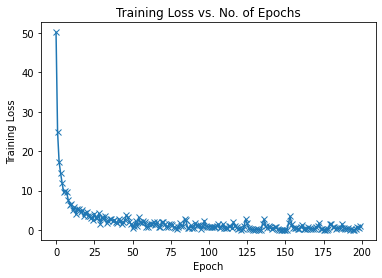

In [34]:
plot_stats(training_loss, 'Training Loss', 'Training Loss vs. No. of Epochs')

##### Plotting Training Accuracy

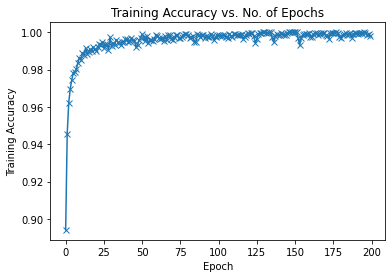

In [35]:
plot_stats(training_acc, 'Training Accuracy', 'Training Accuracy vs. No. of Epochs')

##### Plotting Validation Loss

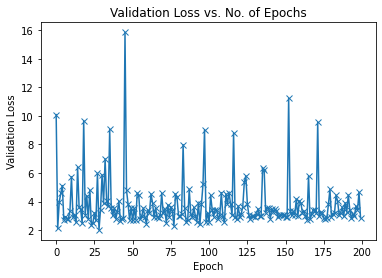

In [36]:
plot_stats(validation_loss, 'Validation Loss', 'Validation Loss vs. No. of Epochs')

##### Plotting Validation Accuracy

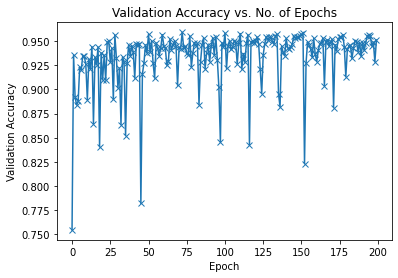

In [37]:
plot_stats(validation_acc, 'Validation Accuracy', 'Validation Accuracy vs. No. of Epochs')

#### Recall Values

In [38]:
test_preds = get_all_preds(model, test_dl)
test_preds_lbl = []
for itr in range(len_testset):
  p = torch.argmax(test_preds[itr])
  test_preds_lbl.append(p.item())

test_actual_lbl = test_actual_labels
recall_scores = recall_score(test_actual_lbl, test_preds_lbl, average=None)
print(f'Class\t\tRecall Value')
for itr in range(10):
  print ("{:<15} {:<15}".format( dataset_classes[itr], recall_scores[itr]))
  #print(f'{dataset_classes[itr]}\t:\t{recall_scores[itr]}')

Class		Recall Value
AnnualCrop      0.965          
Forest          0.9933333333333333
HerbaceousVeg   0.9183333333333333
Highway         0.958          
Industrial      0.964          
Pasture         0.9075         
PermanentCrop   0.914          
Residential     0.9766666666666667
River           0.94           
SeaLake         0.9933333333333333


#### Four examples the model got wrong and was most confident about

In [39]:
recall_scores_np = np.asarray(recall_scores)
recall_scores_np

array([0.965     , 0.99333333, 0.91833333, 0.958     , 0.964     ,
       0.9075    , 0.914     , 0.97666667, 0.94      , 0.99333333])

In [40]:
most_confident = np.argmax(recall_scores_np, axis=0)
most_confident

1

In [41]:
def show_image(img, title):
  plt.title(title)
  plt.imshow(img_1.permute(1,2,0))

In [42]:
example_list = []
for itr in range(len_testset):
  if test_actual_lbl[itr] == most_confident and test_preds_lbl[itr] != most_confident:
    #print(f'{itr} {test_actual_lbl[itr]} {test_preds_lbl[itr]}')
    example = [itr, test_preds_lbl[itr]]
    example_list.append(example)
len_example_list = len(example_list)

total_eg = 0
if len_example_list < 4:
    total_eg = len_example_list
else:
    total_eg = 4

images = []
titles =[]
for itr in range(total_eg):
  index, predicted_lbl = example_list[itr]
  print(f'{index} {predicted_lbl}')
  img, true_label = test_dataset[index]
  img_1 = (img*255).int()
  title = 'Index: ' + str(index) + '\nActual: ' + str(dataset_classes[most_confident]) + '\nPredicted: ' + str(dataset_classes[predicted_lbl])
  images.append(img_1)
  titles.append(title)

486 5
1530 2
3394 5
4676 7


##### Example 1

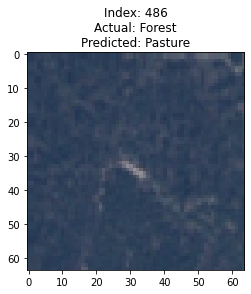

In [43]:
if total_eg > 0:
    show_image(images[0], titles[0])

##### Example 2

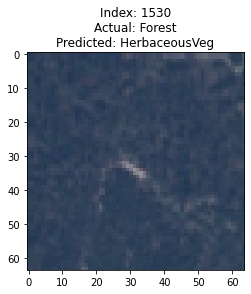

In [44]:
if total_eg > 1:
    show_image(images[1], titles[1])

##### Example 3

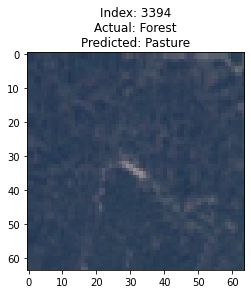

In [45]:
if total_eg > 2:
    show_image(images[2], titles[2])

##### Example 4

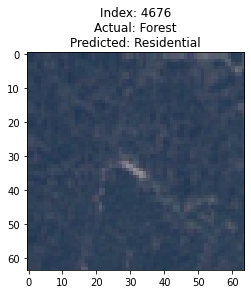

In [46]:
if total_eg > 3:
    show_image(images[3], titles[3])

#### Preparing Reports


Model Accuracy: 0.9553703703703704


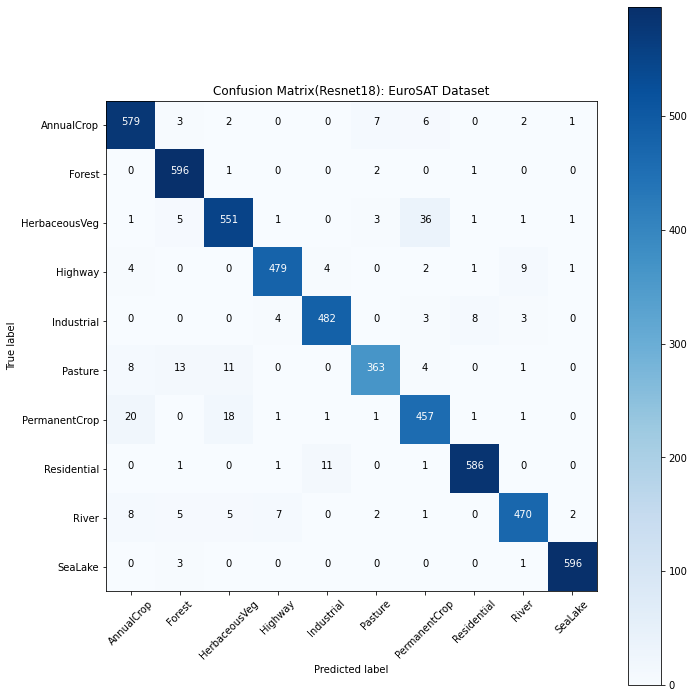

In [47]:
predict_and_prepare_report_on_testdata()